In [ ]:
#Jakub Pawlowicz [22342052] Sophie Ashton [22353313]
#The code executes to the end, we used the 3.13.9 version of Python 
#Third Party Implementation References:
#     DQN ATARI PYTORCH IMPLEMENTATION: https://github.com/qingshi9974/DQN-pytorch-Atari/blob/master/dqn.py
#     OPEN AI WRAPPERS: https://github.com/openai/baselines/blob/edb52c22a5e14324304a491edc0f91b6cc07453b/baselines/common/atari_wrappers.py


# Cell 0: Install packages
!python -m pip install -U pip setuptools wheel

# Install PyTorch with CUDA support
!python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

# Install other dependencies
!python -m pip install -U "gymnasium[atari]"
!python -m pip install opencv-python
!python -m pip install tqdm

Found existing installation: torch 2.9.1+cu128
Uninstalling torch-2.9.1+cu128:
  Successfully uninstalled torch-2.9.1+cu128
Found existing installation: torchvision 0.24.1+cu128
Uninstalling torchvision-0.24.1+cu128:
  Successfully uninstalled torchvision-0.24.1+cu128
Found existing installation: torchaudio 2.9.1+cu128
Uninstalling torchaudio-2.9.1+cu128:
  Successfully uninstalled torchaudio-2.9.1+cu128

INSTALLING PYTORCH WITH CUDA SUPPORT


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Looking in indexes: https://download.pytorch.org/whl/cu128
  Using cached https://download.pytorch.org/whl/cu128/torch-2.9.1%2Bcu128-cp313-cp313-win_amd64.whl.metadata (29 kB)
  Using cached https://download.pytorch.org/whl/cu128/torchvision-0.24.1%2Bcu128-cp313-cp313-win_amd64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu128/torchaudio-2.9.1%2Bcu128-cp313-cp313-win_amd64.whl.metadata (7.0 kB)
Using cached https://download.pytorch.org/whl/cu128/torch-2.9.1%2Bcu128-cp313-cp313-win_amd64.whl (2862.0 MB)
Using cached https://download.pytorch.org/whl/cu128/torchvision-0.24.1%2Bcu128-cp313-cp313-win_amd64.whl (9.6 MB)
Using cached https://download.pytorch.org/whl/cu128/torchaudio-2.9.1%2Bcu128-cp313-cp313-win_amd64.whl (2.2 MB)

   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ------------

## Why Reinforcement Learning is the Machine Learning Paradigm of Choice for This Task

Generally, in Atari games, there is no labelled data set of correct actions, so supervised learning is not a good fit for this project. Like learning any games, just providing the network with a correct set of rules for playing isn't enough. The agent must learn through trial-and-error based reward signals, making Reinforcement Learning the most logical choice for this task. 

Winning a game of Pong relies on sequential decision making, actions change the future state distribution and rewards can be delayed. This creates a credit-assignment problem. Reinforcement learning tackles this using an MDP (Markov Decision Process) $\{S, T, A, R\}$ where:

- $S$: set of states
- $A$: set of actions
- $T(s,a,s') = P(s'\mid s,a)$: probability of transition from state $s$ to $s'$ given action $a$
- $R(s,a)$: expected reward for taking action $a$ in state $s$

## The Gym Environment

We utilised a `gymnasium[atari]` environment interface and ALE Pong-v5 to simulate the environment for the Atari game. The gymnasium acts like a simulator; each time the agent picks an action, the environment executes it, transitions to the next state, and returns a reward.


In [1]:
# Cell 1: Import libraries

# PyTorch imports for deep learning
import torch  # Core PyTorch library for tensors and GPU operations
import torch.nn as nn  # Neural network layers and modules
import torch.nn.functional as F  # Functional operations
import torch.optim as optim  # Optimizers for training

# NumPy for numerical operations and array handling
import numpy as np
import cv2 # OpenCV for image processing
import gymnasium as gym # Gymnasium for pong
import ale_py  # Registers ALE environments
from collections import deque, namedtuple
from tqdm import tqdm # Progress bars for training loops
import random # Random number generation for epsilon-greedy exploration
import os # Operating system interface for file operations

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

print("Imports complete")


Using device: cuda
Imports complete


## Capture and pre-processing of the data

The agent receives raw game frames from the Atari environment and applies preprocessing before learning. We convert the image to grayscale to remove colour and resize the image to [84x84] so we only provide relevant information. We do this using wrappers and we then stack the last four frames together to simulate motion information for the network.  

An experience replay buffer is used to store transitions as experience tuples and then train on random minibatches sampled from that buffer, rather than only the most recent transition

In [2]:
# Cell 2: Wrappers for Atari preprocessing
# Based on OpenAI Baselines but adapted for gymnasium

class NoopResetEnv(gym.Wrapper):
    """
    Random no-op actions at the start of each episode.
    This increases environment diversity by starting from different initial states.
    Helps prevent overfitting to a single starting configuration.
    """
    def __init__(self, env, noop_max=30):
        super().__init__(env)
        self.noop_max = noop_max  # Maximum number of no-op actions (1-30)
        self.noop_action = 0  # Action 0 is typically NOOP in Atari
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        if self.noop_max > 0:
            # Randomly choose number of no-ops (1 to noop_max)
            noops = np.random.randint(1, self.noop_max + 1)
            for _ in range(noops):
                obs, _, terminated, truncated, _ = self.env.step(self.noop_action)
                # If episode ends during no-ops, reset again
                if terminated or truncated:
                    obs, info = self.env.reset(**kwargs)
        return obs, info


class MaxAndSkipEnv(gym.Wrapper):
    """
    Frame skipping: return only every skip-th frame (default skip=4).
    Max-pooling: take maximum pixel values across last 2 frames.
    This speeds up training (4x fewer frames) and reduces flickering artifacts.
    """
    def __init__(self, env, skip=4):
        super().__init__(env)
        self._skip = skip  # Number of frames to skip
        # Buffer to store last 2 frames for max-pooling
        self._obs_buffer = np.zeros((2,) + env.observation_space.shape, dtype=np.uint8)

    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}

        # Repeat the same action for skip frames
        for i in range(self._skip):
            obs, reward, term, trunc, inf = self.env.step(action)

            # Store last 2 frames in circular buffer (i % 2 alternates between 0 and 1)
            # This avoids stale frames if episode ends early
            self._obs_buffer[i % 2] = obs

            total_reward += reward
            terminated = terminated or term
            truncated = truncated or trunc
            info = inf

            if terminated or truncated:
                break

        # Max-pooling: take maximum pixel value across last 2 frames
        # This helps capture fast-moving objects that might be missed in single frames
        max_frame = self._obs_buffer.max(axis=0)
        return max_frame, total_reward, terminated, truncated, info


class WarpFrame(gym.ObservationWrapper):
    """
    Preprocess frames: convert to grayscale and resize to 84x84.
    This matches the DQN paper specification and reduces input dimensionality.
    """
    def __init__(self, env):
        super().__init__(env)
        self.width = 84
        self.height = 84
        # Update observation space to reflect preprocessed frame size
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(self.height, self.width), dtype=np.uint8
        )
    
    def observation(self, frame):
        # Convert RGB to grayscale (reduces channels from 3 to 1)
        if len(frame.shape) == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        # Resize to 84x84 using area interpolation (good for downsampling)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame


class ClipRewardEnv(gym.RewardWrapper):
    """
    Clip rewards to {-1, 0, +1} based on sign.
    This normalizes rewards across different Atari games and stabilizes training.
    Original rewards (e.g., +1, +2, +5) all become +1; negative rewards become -1.
    """
    def reward(self, reward):
        return np.sign(reward)  # Returns -1, 0, or +1


class FrameStack(gym.Wrapper):
    """
    Stack the last k frames (default k=4) along a new channel dimension.
    This provides temporal information - the network can see object motion.
    Uses deque for efficient memory management (automatically removes oldest frame).
    """
    def __init__(self, env, k=4):
        super().__init__(env)
        self.k = k  # Number of frames to stack
        # Deque automatically maintains only last k frames
        self.frames = deque([], maxlen=k)
        obs_shape = env.observation_space.shape
        # Update observation space: (height, width) -> (k, height, width)
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(k, *obs_shape), dtype=np.uint8
        )
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # Initialize frame stack with the same frame repeated k times
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_obs(), info
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        # Add new frame (deque automatically removes oldest if at capacity)
        self.frames.append(obs)
        return self._get_obs(), reward, terminated, truncated, info
    
    def _get_obs(self):
        assert len(self.frames) == self.k
        # Stack frames along axis 0: creates shape (k, height, width)
        return np.stack(self.frames, axis=0)

class FireResetEnv(gym.Wrapper):
    """
    Automatically press FIRE button at the start of each episode.
    Many Atari games (like Pong) require pressing FIRE to begin gameplay.
    Without this, the agent would waste time learning to press FIRE first.
    """
    def __init__(self, env):
        super().__init__(env)
        # Action 1 is  FIRE in Atari games
        self.fire_action = 1
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # Press FIRE to start the game
        obs, _, terminated, truncated, info = self.env.step(self.fire_action)
        # If episode ends immediately (shouldn't happen), reset again
        if terminated or truncated:
            obs, info = self.env.reset(**kwargs)
        return obs, info


def make_atari_env(env_id='ALE/Pong-v5', max_episode_steps=108000, sticky_actions=False):
    
    # Create and configure Atari environment with all preprocessing wrappers
    
    # Create base environment with minimal frame skipping
    env = gym.make(
        env_id,
        frameskip=1,  # Critical: prevents 4x4=16 frame skipping when combined with MaxAndSkipEnv
        repeat_action_probability=0.0,  # No sticky actions
        full_action_space=False,  # Reduced action space (6 actions for Pong)
    )

    # Set maximum episode length
    env._max_episode_steps = max_episode_steps

    # Apply wrappers in order
    env = NoopResetEnv(env, noop_max=30)  # Random no-ops at episode start
    env = FireResetEnv(env)  # Press FIRE to start game
    env = MaxAndSkipEnv(env, skip=4)  # Frame skipping with max-pooling
    env = WarpFrame(env)  # Grayscale and resize to 84x84
    env = ClipRewardEnv(env)  # Clip rewards to {-1, 0, +1}
    env = FrameStack(env, k=4)  # Stack last 4 frames
    return env


# Test the environment wrapper
# Verify that observation shape is (4, 84, 84) - 4 stacked frames of 84x84 pixels
test_env = make_atari_env()
test_obs, _ = test_env.reset()
print(f"Observation shape: {test_obs.shape}, dtype: {test_obs.dtype}")
print(f"Action space: {test_env.action_space}")
test_env.close()

Observation shape: (4, 84, 84), dtype: uint8
Action space: Discrete(6)


## The network structure  

The Q network is a CNN that maps a stacked state [4 x 84 x 84] to one Q-value per action. The structure of the network is: 

    Conv1: 32 filters, 8x8, stride 4 + ReLU 

    Conv2: 64 filters, 4x4, stride 2 + ReLU 

    Conv3: 64 filters, 3x3, stride 1 + ReLU 

    FC: 512 ReLU units 

    Output: fully-connected linear layer with one Q-value per action 

In this implementation, we use channels first, so that is why the input is [4 x 84 x 84]. We normalise the pixel inputs by dividing by 255 to bring values into a bounded range of [0,1]. Doing this provides stability and helps gradient-based optimisation converge more reliably.  

In [3]:
# Cell 3: DQN Network Model

class DQNNetwork(nn.Module):
    """DQN CNN network for Atari games."""
    def __init__(self, n_actions, n_frames=4):
        # Call parent class constructor to initialize PyTorch Module
        super(DQNNetwork, self).__init__()
        
        # Convolutional layers
        # First conv layer: 4 input channels -> 32 output channels
        # Kernel size 8x8 with stride 4: reduces spatial size from 84x84
        self.conv1 = nn.Conv2d(n_frames, 32, kernel_size=8, stride=4)
        # Second conv layer: 32 -> 64 channels, kernel 4x4 stride 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        # Third conv layer: 64 -> 64 channels, kernel 3x3 stride 1
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Fully connected layers
        # Output size after conv layers: 7x7x64 = 3136
        # First FC: 3136 features -> 512 hidden units
        self.fc1 = nn.Linear(7 * 7 * 64, 512)
        # Second FC: 512 -> n_actions
        self.fc2 = nn.Linear(512, n_actions)
        
        # Initialize weights using He initialization for better training
        self._initialize_weights()
    
    def _initialize_weights(self):
        # Iterate through all modules in the network
        for m in self.modules():
            # Apply initialization to convolutional and linear layers only
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                # He initialization
                # mode='fan_out': uses number of output features for scaling
                # nonlinearity='relu': accounts for ReLU's non-linearity
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                # Initialize biases to zero if they exist
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Normalize pixel values from [0, 255] to [0, 1] by converting to float and dividing
        x = x.float() / 255.0
        
        # Convolutional layers with ReLU activation
        # Apply first conv layer followed by ReLU
        x = F.relu(self.conv1(x))
        # Apply second conv layer followed by ReLU
        x = F.relu(self.conv2(x))
        # Apply third conv layer followed by ReLU
        x = F.relu(self.conv3(x))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        # First FC layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Second FC layer: no activation outputs raw Q-values
        x = self.fc2(x)
        
        # Return Q-values for each action
        return x


# Test the model to verify it works correctly
# Get device GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print which device will be used
print(f"Using device: {device}")

# Create model instance: 6 actions (for Pong) with 4 stacked frames
test_model = DQNNetwork(n_actions=6, n_frames=4).to(device)
# Create test input: batch_size=1, 4 channels, 84x84 pixels, uint8 dtype
test_input = torch.zeros(1, 4, 84, 84, dtype=torch.uint8).to(device)
# Forward pass through the model
test_output = test_model(test_input)
# Print input and output shapes to verify model architecture
print(f"Model setup\nInput shape: {test_input.shape}, Output shape: {test_output.shape}")

Using device: cuda
Model setup
Input shape: torch.Size([1, 4, 84, 84]), Output shape: torch.Size([1, 6])


## Experience Replay Buffer: Countering Catastrophic Forgetting

Catastrophic forgetting occurs when a neural network overwrites previously learned information while learning new patterns. In reinforcement learning this can happen when the agent only trains on recent experiences causing it to forget earlier strategies.

An experience replay buffer helps with this by saving old transitions (state, action, reward, next_state, done) in a circular memory with a fixed size (we used 250,000 experiences). When training the agent picks random minibatches from this memory instead of only learning from the newest transitions.

In our setup, we sample uniformly at random from the replay buffer. This means experiences from the whole training process can affect the weight updates, helping the agent stay good at states it saw earlier even while it explores new parts of the state space.

The replay buffer helps in a few important ways:

More stable training: Instead of learning from experiences in order, the agent learns from random samples. This matters because game frames right next to each other are really similar, and training on them in order can make learning jumpy or unstable.

Better use of data: The buffer lets the agent reuse the same experience multiple times. Without it, each experience would only be used once, so you’d need way more gameplay to learn the same amount.

Helps avoid catastrophic forgetting: In our implementation, the agent keeps improving across 5 million training steps and doesn’t “forget” what it learned earlier. You can see this because rewards go from negative values to positive values around +14, which suggests the agent is holding onto useful strategies while still learning new ones.

Matches what we saw in results: The rewards steadily increase over time from around -20 (basically random play) to about +14 (winning consistently). That kind of long-term improvement would be much harder without a replay buffer keeping a mix of old and new experiences.

We used a replay buffer size of 250,000 experiences, which is a good middle ground. It’s large enough to keep a wide variety of experiences from different parts of training, but not so big that it becomes slow or inefficient to use.


In [4]:
# CELL 4: Replay Buffer

# Define a named tuple structure for storing experience tuples
# Each experience contains: state, action taken, reward received, next state, and done flag
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    """
    Replay buffer for DQN.
    Uses numpy arrays for efficient storage.
    
    The capacity parameter acts as max_memory_length - when the buffer is full,
    new entries automatically overwrite the oldest entries.
    This prevents memory from growing unbounded.
    """
    def __init__(self, capacity=250000):  # capacity = max_memory_length
        # Maximum number of experiences the buffer can hold
        self.capacity = capacity
        # Current number of experiences stored
        self.size = 0
        # Pointer to next position to write
        self.ptr = 0
        
        # Pre-allocate numpy arrays for efficient storage
        # State shape: (4, 84, 84) uint8, stores current state frames
        self.states = np.zeros((capacity, 4, 84, 84), dtype=np.uint8)
        # Next state shape: (4, 84, 84) uint8, stores next state after action
        self.next_states = np.zeros((capacity, 4, 84, 84), dtype=np.uint8)
        # Actions: integer array storing action indices
        self.actions = np.zeros(capacity, dtype=np.int64)
        # Rewards: float array storing reward values
        self.rewards = np.zeros(capacity, dtype=np.float32)
        # Dones: float array storing done flags
        self.dones = np.zeros(capacity, dtype=np.float32)
    
    def push(self, state, action, reward, next_state, done):
        """
        Add experience to buffer.
        Automatically overwrites oldest entry when buffer is full.
        This prevents memory from growing unbounded.
        """
        # Store current state at current pointer position
        self.states[self.ptr] = state
        # Store next state at current pointer position
        self.next_states[self.ptr] = next_state
        # Store action at current pointer position
        self.actions[self.ptr] = action
        # Store reward at current pointer position
        self.rewards[self.ptr] = reward
        # Store done flag (convert boolean to float: True=1.0, False=0.0)
        self.dones[self.ptr] = float(done)
        
        # Circular buffer wrap around and overwrite oldest entry when full
        # Increment pointer, wrapping around to 0 when reaching capacity
        self.ptr = (self.ptr + 1) % self.capacity
        # Update size: increases until capacity is reached, then stays constant
        self.size = min(self.size + 1, self.capacity)
    
    def sample(self, batch_size, device):
        """Sample batch of experiences."""
        # Randomly select batch_size indices from [0, size) without replacement
        indices = np.random.randint(0, self.size, size=batch_size)
        
        # Use pre-allocated arrays for efficiency
        # Convert numpy arrays to PyTorch tensors and move to specified device
        # States: uint8 tensors (pixel values 0-255)
        states = torch.tensor(self.states[indices], dtype=torch.uint8, device=device)
        # Actions: long tensors (integer action indices)
        actions = torch.tensor(self.actions[indices], dtype=torch.long, device=device)
        # Rewards: float32 tensors (reward values)
        rewards = torch.tensor(self.rewards[indices], dtype=torch.float32, device=device)
        # Next states: uint8 tensors (next state frames)
        next_states = torch.tensor(self.next_states[indices], dtype=torch.uint8, device=device)
        # Dones: float32 tensors (episode termination flags)
        dones = torch.tensor(self.dones[indices], dtype=torch.float32, device=device)
        
        # Return batch of experiences as PyTorch tensors ready for training
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        # Return current number of experiences stored
        return self.size


# Print confirmation that replay buffer is ready to use
print("Replay Buffer ready")

Replay Buffer ready


## Applying Q-learning update to the weights 

The Q-learning idea consists of moving the predicted Q-value toward a bootstrapped target.  

For each transition we define a target: 

$$y_t = r_t + (1 - \text{done}) \gamma \max_{a'} Q(s_{t+1}, a'; \theta^-)$$

And the network's prediction: 

$$q_t = Q(s_t, a_t; \theta)$$

We compute Q-values for all actions using the online network, and then select only the value for the action taken:

```python
q_values = self.q_network(states)   
q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)   
```

In this snippet, `q_values` corresponds to $Q(s, \cdot; \theta)$ and `q_value` corresponds to $Q(s, a; \theta)$, or the predicted term.

### Error and Loss

In this DQN, the error that we're trying to reduce is the Temporal-difference error between the network's current Q-value prediction and the network's target Q-value. This target is computed from the reward plus discounted estimated future return, formulised as: 

$$r + \gamma \max Q(s_{t+1}, \cdot; \theta^-)$$

```python
with torch.no_grad():  
    next_q_values = self.target_network(next_states) 
    next_q_value = next_q_values.max(1)[0]  
    target_q_value = rewards + (1 - dones) * self.gamma * next_q_value 
```

For the loss function, we used Smooth L1 loss instead of a squared loss like MSE. Smooth L1 loss combines the behaviour of MSE for small errors and MAE for large errors. This makes our training more stable in the event that transitions produce unusually large TD errors.

### The weight update:

Updating the weights helps to reduce the TD error between the network's current prediction and the target. Applying a gradient-based update allows future Q-value predictions move closer to the target.

```python
self.optimizer.zero_grad() 
loss.backward() 
torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 10) 
self.optimizer.step() 
```

- `loss.backward()` computes gradients $\nabla_\theta L$ via backprop
- `optimizer.step()` applies the update to the Q-network weights
- Gradient clipping is used for stability


In [5]:
# CELL 5: DQN Agent

class DQNAgent:
    """DQN Agent with experience replay and target network."""
    def __init__(
        self,
        n_actions,
        device,
        lr=1e-4,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.1,
        epsilon_decay_steps=1000000,
        target_update_freq=10000,
        buffer_size=1000000,
        batch_size=32
    ):
        # Store number of possible actions in the environment
        self.n_actions = n_actions
        # Store device for tensor operations
        self.device = device
        # Discount factor: how much future rewards are valued (0.99 = high value on future)
        self.gamma = gamma
        # Starting epsilon for epsilon-greedy exploration (1.0 = 100% random initially)
        self.epsilon_start = epsilon_start
        # Ending epsilon after decay (0.1 = 10% random, 90% greedy)
        self.epsilon_end = epsilon_end
        # Number of steps over which epsilon decays linearly
        self.epsilon_decay_steps = epsilon_decay_steps
        # Frequency for updating target network
        self.target_update_freq = target_update_freq
        # Batch size for training
        self.batch_size = batch_size
        # Counter for total training steps taken
        self.steps = 0
        
        # Networks
        # Main Q-network learns to predict Q-values for state-action pairs
        self.q_network = DQNNetwork(n_actions).to(device)
        # Target network provides stable Q-value targets during training
        # Initialized with same weights as main network
        self.target_network = DQNNetwork(n_actions).to(device)
        # Copy weights from main network to target network
        self.target_network.load_state_dict(self.q_network.state_dict())
        # Set target network to evaluation mode
        self.target_network.eval()
        
        # Optimizer
        # Adam optimizer for updating Q-network weights
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr, eps=1.5e-4)
        
        # Replay buffer
        # Stores past experiences for training
        self.replay_buffer = ReplayBuffer(buffer_size)
    
    def get_epsilon(self):
        """
        Get current epsilon value using linear decay.
        """
        # Check if we're still in the decay phase
        if self.steps < self.epsilon_decay_steps:
            # Linear decay: goes from start to end over decay_steps
            # Calculate current epsilon: decreases linearly as steps increase
            epsilon = self.epsilon_start - (self.epsilon_start - self.epsilon_end) * (self.steps / self.epsilon_decay_steps)
            # Ensure epsilon doesn't go below epsilon_end
            return max(epsilon, self.epsilon_end)
        # After decay period, return final epsilon value
        return self.epsilon_end
    
    def select_action(self, state, training=True):
        """Select action using epsilon-greedy policy."""
        # Epsilon-greedy: with probability epsilon, choose random action (exploration)
        # Only do random exploration during training, not during evaluation
        if training and np.random.random() < self.get_epsilon():
            # Random exploration: choose uniformly random action
            return np.random.randint(self.n_actions)
        
        # Greedy action: choose action with highest Q-value (exploitation)
        # Disable gradient computation for inference
        with torch.no_grad():
            # Convert state numpy array to PyTorch tensor
            # unsqueeze(0) adds batch dimension: (4,84,84) -> (1,4,84,84)
            state_tensor = torch.tensor(state, dtype=torch.uint8, device=self.device).unsqueeze(0)
            # Forward pass: get Q-values for all actions
            q_values = self.q_network(state_tensor)
            # argmax(1) finds action with highest Q-value, item() extracts scalar value
            return q_values.argmax(1).item()
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in replay buffer."""
        # Add experience tuple (s, a, r, s', done) to replay buffer
        self.replay_buffer.push(state, action, reward, next_state, done)
        # Increment step counter
        self.steps += 1
    
    def train_step(self):
        """Perform one training step."""
        # Check if buffer has enough experiences for a batch
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample batch
        # Randomly sample batch_size experiences from replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(
            self.batch_size, self.device
        )
        
        # Compute Q-values
        # Forward pass: get Q-values for all actions for all states in batch
        q_values = self.q_network(states)
        # Extract Q-value for the action that was actually taken
        # gather(1, actions.unsqueeze(1)) selects Q-value at action index for each sample
        # squeeze(1) removes the extra dimension: (batch, 1) -> (batch,)
        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute target Q-values using target network
        # Disable gradients for target computation
        with torch.no_grad():
            # Get Q-values for next states using target network
            next_q_values = self.target_network(next_states)
            # Bellman equation: Q*(s,a) = r + gamma * max_a' Q*(s',a')
            # max(1)[0] gets maximum Q-value across actions for each next state
            next_q_value = next_q_values.max(1)[0]
            # Compute target: r + gamma * max Q(s',a')
            # (1 - dones) zeros out future reward if episode ended
            target_q_value = rewards + (1 - dones) * self.gamma * next_q_value
        
        # Compute loss and optimize
        # Smooth L1 loss (Huber loss)
        loss = F.smooth_l1_loss(q_value, target_q_value)

        
        # Zero out gradients from previous iteration
        self.optimizer.zero_grad()
        # Backward pass compute gradients
        loss.backward()
        # Gradient clipping for stability prevents exploding gradients
        # Clips gradient norm to maximum of 10
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 10)
        # Update network weights using computed gradients
        self.optimizer.step()
        
        # Update target network periodically
        # Copy weights from main network to target network every target_update_freq steps
        # This provides stable targets for Q-learning
        if self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Return loss value as Python float
        return loss.item()
    
    def save(self, filepath):
        """Save model."""
        # Save all necessary components to resume training later
        torch.save({
            # Save Q-network weights
            'q_network': self.q_network.state_dict(),
            # Save target network weights
            'target_network': self.target_network.state_dict(),
            # Save optimizer state
            'optimizer': self.optimizer.state_dict(),
            # Save training step count
            'steps': self.steps,
        }, filepath)
    
    def load(self, filepath):
        """Load model."""
        # Load checkpoint from file mapping to correct device
        checkpoint = torch.load(filepath, map_location=self.device)
        # Restore Q-network weights
        self.q_network.load_state_dict(checkpoint['q_network'])
        # Restore target network weights
        self.target_network.load_state_dict(checkpoint['target_network'])
        # Restore optimizer state
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        # Restore step count
        self.steps = checkpoint['steps']


# Print confirmation
print("DQN Agent ready")

DQN Agent ready


In [ ]:
# CELL 6: Training Loop

# Hyperparameters
# Total number of environment steps to train for
TOTAL_STEPS = 5000000
# Number of steps before starting to train
LEARN_START = 50000
# Train every N steps
TRAIN_FREQ = 4
# Save model checkpoint every N steps
SAVE_FREQ = 200000
# Print evaluation statistics every N steps
EVAL_FREQ = 50000

# Create environment
# Initialize Pong environment with all preprocessing wrappers
env = make_atari_env('ALE/Pong-v5')
# Get number of possible actions (6 for Pong: NOOP, UP, DOWN, FIRE, UP+FIRE, DOWN+FIRE)
n_actions = env.action_space.n

# Create agent
agent = DQNAgent(
    n_actions=n_actions,  # Number of actions in action space
    device=device,  # Set device
    lr=1e-4,  # Learning rate for Adam optimizer
    gamma=0.99,  # Discount factor for future rewards
    epsilon_start=1.0,  # Initial exploration rate (100% random)
    epsilon_end=0.1,  # Final exploration rate (10% random)
    epsilon_decay_steps=1000000,  # Steps over which epsilon decays
    target_update_freq=10000,  # Update target network every N steps
    buffer_size=250000,  # Buffer size
    batch_size=32  # Number of experiences per training batch
)

# Training statistics
# Use deque with maxlen to automatically pop old history and prevent memory growth
MAX_EPISODE_HISTORY = 10000
# Store rewards for each completed episode
episode_rewards = deque(maxlen=MAX_EPISODE_HISTORY)
# Store episode lengths
episode_lengths = deque(maxlen=MAX_EPISODE_HISTORY)
# Track reward for current episode
current_reward = 0
# Track length of current episode
current_length = 0

# Create models directory
# Create directory for saving model checkpoints
os.makedirs('models', exist_ok=True)

# Print training configuration
print(f"Starting training for {TOTAL_STEPS:,} steps")
print(f"Environment: Pong")
print(f"Actions: {n_actions}")
print(f"Device: {device}")

# Initialize state
# Reset environment and get initial observation
state, info = env.reset()

# Training loop
# Create progress bar to show training progress
pbar = tqdm(range(TOTAL_STEPS), desc="Training")

# Main training loop: iterate for TOTAL_STEPS environment steps
for step in pbar:
    # Select action
    # Use epsilon-greedy policy: random exploration or greedy exploitation
    action = agent.select_action(state, training=True)
    
    # Take step
    # Execute action in environment and observe result
    next_state, reward, terminated, truncated, info = env.step(action)
    # Combine terminated and truncated flags
    done = terminated or truncated
    
    # Store transition
    # Add experience (state, action, reward, next_state, done) to replay buffer
    agent.store_transition(state, action, reward, next_state, done)
    
    # Update statistics
    # Accumulate reward for current episode
    current_reward += reward
    # Increment step counter for current episode
    current_length += 1
    
    # Train
    # Only train after buffer has enough samples (LEARN_START) and every TRAIN_FREQ steps
    if agent.steps >= LEARN_START and agent.steps % TRAIN_FREQ == 0:
        # Perform one training step (sample batch, compute loss, update network)
        loss = agent.train_step()
        # Update progress bar with current metrics if training occurred
        if loss is not None:
            # Convert deque to list for numpy operations
            # Calculate average reward over last 10 episodes
            avg_reward = np.mean(list(episode_rewards)[-10:]) if len(episode_rewards) >= 10 else 0
            # Update progress bar display with current metrics
            pbar.set_postfix({
                'epsilon': f'{agent.get_epsilon():.3f}',  # Current exploration rate
                'loss': f'{loss:.4f}',  # Current training loss
                'avg_reward': f'{avg_reward:.1f}' if len(episode_rewards) >= 10 else 'N/A'  # Recent performance
            })
    
    # Handle episode end
    if done:
        # Episode finished: save statistics and reset
        episode_rewards.append(current_reward)  # Store total reward for episode
        episode_lengths.append(current_length)  # Store episode length
        current_reward = 0  # Reset reward counter for next episode
        current_length = 0  # Reset length counter for next episode
        # Reset environment and get new initial state
        state, info = env.reset()
    else:
        # Episode continues: move to next state
        state = next_state
    
    # Save model
    # Save checkpoint periodically for recovery and evaluation
    if step > 0 and step % SAVE_FREQ == 0:
        # Create filename with step count in thousands
        model_path = f'models/dqn_pong_{step//1000}k.pth'
        # Save agent state
        agent.save(model_path)
        print(f"\n💾 Model saved: {model_path}")
    
    # Evaluate
    # Print detailed statistics periodically
    if step > 0 and step % EVAL_FREQ == 0 and len(episode_rewards) >= 10:
        # Convert deque to list for numpy operations
        rewards_list = list(episode_rewards)
        lengths_list = list(episode_lengths)
        # Calculate average reward over last 10 episodes
        avg_reward = np.mean(rewards_list[-10:])
        # Calculate average episode length over last 10 episodes
        avg_length = np.mean(lengths_list[-10:])
        # Print evaluation statistics
        print(f"\nStep {step:,}:")
        print(f"   Avg reward (last 10): {avg_reward:.2f}")
        print(f"   Avg length: {avg_length:.1f}")
        print(f"   Epsilon: {agent.get_epsilon():.3f}")
        

# Final save
# Save final model checkpoint after training completes
agent.save('models/dqn_pong_final.pth')
# Close environment to free resources
env.close()
# Close progress bar
pbar.close()

# Print final training summary
print(f"\nTraining complete!")
print(f"Total episodes recorded: {len(episode_rewards)}")
# Print final performance statistics if we have episode data
if len(episode_rewards) > 0:
    # Convert deque to list for numpy operations
    rewards_list = list(episode_rewards)
    # Calculate average reward over last 100 episodes
    print(f"Final avg reward (last 100): {np.mean(rewards_list[-100:]):.2f}")
    # Find and print best episode reward achieved during training
    print(f"Best episode: {max(rewards_list):.2f}")

Starting training for 5,000,000 steps
Environment: Pong
Actions: 6
Device: cuda


Training:   1%|          | 49830/5000000 [00:18<33:55, 2432.50it/s, epsilon=0.955, loss=0.1181, avg_reward=-20.6]


Step 50,000:
   Avg reward (last 10): -20.60
   Avg length: 905.8
   Epsilon: 0.955


Training:   2%|▏         | 100100/5000000 [01:10<1:25:40, 953.26it/s, epsilon=0.910, loss=0.0055, avg_reward=-20.3]


Step 100,000:
   Avg reward (last 10): -20.30
   Avg length: 896.4
   Epsilon: 0.910


Training:   3%|▎         | 150148/5000000 [02:03<1:25:40, 943.37it/s, epsilon=0.865, loss=0.0081, avg_reward=-20.5]


Step 150,000:
   Avg reward (last 10): -20.50
   Avg length: 905.9
   Epsilon: 0.865


Training:   4%|▍         | 200176/5000000 [02:57<1:28:39, 902.28it/s, epsilon=0.820, loss=0.0086, avg_reward=-20.2]


💾 Model saved: models2/dqn_pong_200k.pth

Step 200,000:
   Avg reward (last 10): -20.20
   Avg length: 939.5
   Epsilon: 0.820


Training:   5%|▌         | 250140/5000000 [03:52<1:25:58, 920.81it/s, epsilon=0.775, loss=0.0058, avg_reward=-19.3]


Step 250,000:
   Avg reward (last 10): -19.30
   Avg length: 1011.4
   Epsilon: 0.775


Training:   6%|▌         | 300144/5000000 [04:50<1:31:39, 854.67it/s, epsilon=0.730, loss=0.0109, avg_reward=-19.7]


Step 300,000:
   Avg reward (last 10): -19.70
   Avg length: 1014.6
   Epsilon: 0.730


Training:   7%|▋         | 350086/5000000 [05:49<1:30:16, 858.47it/s, epsilon=0.685, loss=0.0175, avg_reward=-20.2]


Step 350,000:
   Avg reward (last 10): -20.20
   Avg length: 1024.0
   Epsilon: 0.685


Training:   8%|▊         | 400148/5000000 [06:48<1:36:10, 797.18it/s, epsilon=0.640, loss=0.0122, avg_reward=-19.9]


💾 Model saved: models2/dqn_pong_400k.pth

Step 400,000:
   Avg reward (last 10): -19.90
   Avg length: 1063.0
   Epsilon: 0.640


Training:   9%|▉         | 450097/5000000 [07:49<1:32:54, 816.13it/s, epsilon=0.595, loss=0.0079, avg_reward=-18.3]


Step 450,000:
   Avg reward (last 10): -18.30
   Avg length: 1291.8
   Epsilon: 0.595


Training:  10%|█         | 500154/5000000 [08:51<1:31:42, 817.81it/s, epsilon=0.550, loss=0.0038, avg_reward=-18.9]


Step 500,000:
   Avg reward (last 10): -18.90
   Avg length: 1244.8
   Epsilon: 0.550


Training:  11%|█         | 550092/5000000 [09:53<1:31:14, 812.84it/s, epsilon=0.505, loss=0.0052, avg_reward=-18.6]


Step 550,000:
   Avg reward (last 10): -18.60
   Avg length: 1343.0
   Epsilon: 0.505


Training:  12%|█▏        | 600094/5000000 [10:56<1:35:21, 769.06it/s, epsilon=0.460, loss=0.0143, avg_reward=-17.5]


💾 Model saved: models2/dqn_pong_600k.pth

Step 600,000:
   Avg reward (last 10): -17.50
   Avg length: 1429.9
   Epsilon: 0.460


Training:  13%|█▎        | 650126/5000000 [12:00<1:33:20, 776.67it/s, epsilon=0.415, loss=0.0146, avg_reward=-17.7]


Step 650,000:
   Avg reward (last 10): -17.70
   Avg length: 1421.9
   Epsilon: 0.415


Training:  14%|█▍        | 700144/5000000 [13:05<1:31:15, 785.30it/s, epsilon=0.370, loss=0.0071, avg_reward=-16.4]


Step 700,000:
   Avg reward (last 10): -16.40
   Avg length: 1561.2
   Epsilon: 0.370


Training:  15%|█▌        | 750086/5000000 [14:10<1:33:32, 757.20it/s, epsilon=0.325, loss=0.0054, avg_reward=-16.0]


Step 750,000:
   Avg reward (last 10): -16.00
   Avg length: 1821.5
   Epsilon: 0.325


Training:  16%|█▌        | 800077/5000000 [15:16<1:36:30, 725.36it/s, epsilon=0.280, loss=0.0076, avg_reward=-16.1]


💾 Model saved: models2/dqn_pong_800k.pth

Step 800,000:
   Avg reward (last 10): -16.10
   Avg length: 1617.6
   Epsilon: 0.280


Training:  17%|█▋        | 850128/5000000 [16:23<1:32:59, 743.74it/s, epsilon=0.235, loss=0.0059, avg_reward=-16.9]


Step 850,000:
   Avg reward (last 10): -16.90
   Avg length: 1687.9
   Epsilon: 0.235


Training:  18%|█▊        | 900111/5000000 [17:30<1:32:00, 742.62it/s, epsilon=0.190, loss=0.0041, avg_reward=-15.3]


Step 900,000:
   Avg reward (last 10): -15.30
   Avg length: 1880.0
   Epsilon: 0.190


Training:  19%|█▉        | 950112/5000000 [18:39<1:34:38, 713.16it/s, epsilon=0.145, loss=0.0059, avg_reward=-14.8]


Step 950,000:
   Avg reward (last 10): -14.80
   Avg length: 1950.4
   Epsilon: 0.145


Training:  20%|██        | 1000126/5000000 [19:48<1:36:31, 690.63it/s, epsilon=0.100, loss=0.0086, avg_reward=-13.2]


💾 Model saved: models2/dqn_pong_1000k.pth

Step 1,000,000:
   Avg reward (last 10): -13.20
   Avg length: 2214.2
   Epsilon: 0.100


Training:  21%|██        | 1050120/5000000 [20:58<1:32:33, 711.30it/s, epsilon=0.100, loss=0.0051, avg_reward=-13.8]


Step 1,050,000:
   Avg reward (last 10): -14.40
   Avg length: 1997.5
   Epsilon: 0.100


Training:  22%|██▏       | 1100140/5000000 [22:07<1:26:01, 755.55it/s, epsilon=0.100, loss=0.0100, avg_reward=-13.8]


Step 1,100,000:
   Avg reward (last 10): -13.80
   Avg length: 2022.0
   Epsilon: 0.100


Training:  23%|██▎       | 1150116/5000000 [23:14<1:25:48, 747.73it/s, epsilon=0.100, loss=0.0033, avg_reward=-11.9]


Step 1,150,000:
   Avg reward (last 10): -11.90
   Avg length: 2214.4
   Epsilon: 0.100


Training:  24%|██▍       | 1200084/5000000 [24:20<1:29:12, 709.99it/s, epsilon=0.100, loss=0.0108, avg_reward=-9.6] 


💾 Model saved: models2/dqn_pong_1200k.pth

Step 1,200,000:
   Avg reward (last 10): -9.60
   Avg length: 2527.5
   Epsilon: 0.100


Training:  25%|██▌       | 1250117/5000000 [25:27<1:23:36, 747.57it/s, epsilon=0.100, loss=0.0255, avg_reward=-8.9] 


Step 1,250,000:
   Avg reward (last 10): -8.90
   Avg length: 2547.7
   Epsilon: 0.100


Training:  26%|██▌       | 1300138/5000000 [26:33<1:23:25, 739.19it/s, epsilon=0.100, loss=0.0252, avg_reward=-9.5] 


Step 1,300,000:
   Avg reward (last 10): -9.50
   Avg length: 2601.9
   Epsilon: 0.100


Training:  27%|██▋       | 1350080/5000000 [27:43<1:24:13, 722.29it/s, epsilon=0.100, loss=0.0038, avg_reward=-5.1]


Step 1,350,000:
   Avg reward (last 10): -5.10
   Avg length: 2894.8
   Epsilon: 0.100


Training:  28%|██▊       | 1400120/5000000 [28:52<1:27:52, 682.83it/s, epsilon=0.100, loss=0.0033, avg_reward=-6.6]


💾 Model saved: models2/dqn_pong_1400k.pth

Step 1,400,000:
   Avg reward (last 10): -6.60
   Avg length: 2824.2
   Epsilon: 0.100


Training:  29%|██▉       | 1450132/5000000 [30:02<1:20:18, 736.78it/s, epsilon=0.100, loss=0.0055, avg_reward=-4.1]


Step 1,450,000:
   Avg reward (last 10): -4.10
   Avg length: 3020.9
   Epsilon: 0.100


Training:  30%|███       | 1500091/5000000 [31:11<1:20:56, 720.72it/s, epsilon=0.100, loss=0.0070, avg_reward=-4.5]


Step 1,500,000:
   Avg reward (last 10): -4.80
   Avg length: 3009.3
   Epsilon: 0.100


Training:  31%|███       | 1550136/5000000 [32:20<1:19:11, 726.13it/s, epsilon=0.100, loss=0.0232, avg_reward=-5.1]


Step 1,550,000:
   Avg reward (last 10): -5.10
   Avg length: 2962.0
   Epsilon: 0.100


Training:  32%|███▏      | 1600094/5000000 [33:30<1:23:11, 681.09it/s, epsilon=0.100, loss=0.0044, avg_reward=-2.2]


💾 Model saved: models2/dqn_pong_1600k.pth

Step 1,600,000:
   Avg reward (last 10): -2.20
   Avg length: 3238.0
   Epsilon: 0.100


Training:  33%|███▎      | 1650091/5000000 [34:40<1:16:15, 732.09it/s, epsilon=0.100, loss=0.0057, avg_reward=0.8] 


Step 1,650,000:
   Avg reward (last 10): 0.80
   Avg length: 3309.2
   Epsilon: 0.100


Training:  34%|███▍      | 1700088/5000000 [35:49<1:15:31, 728.14it/s, epsilon=0.100, loss=0.0040, avg_reward=1.8] 


Step 1,700,000:
   Avg reward (last 10): 1.80
   Avg length: 3225.7
   Epsilon: 0.100


Training:  35%|███▌      | 1750134/5000000 [36:58<1:17:02, 703.01it/s, epsilon=0.100, loss=0.0047, avg_reward=3.9]


Step 1,750,000:
   Avg reward (last 10): 3.90
   Avg length: 3116.3
   Epsilon: 0.100


Training:  36%|███▌      | 1800118/5000000 [38:08<1:17:58, 683.88it/s, epsilon=0.100, loss=0.0041, avg_reward=1.7] 


💾 Model saved: models2/dqn_pong_1800k.pth

Step 1,800,000:
   Avg reward (last 10): 1.70
   Avg length: 2867.8
   Epsilon: 0.100


Training:  37%|███▋      | 1850116/5000000 [39:18<1:13:30, 714.13it/s, epsilon=0.100, loss=0.0033, avg_reward=3.7]


Step 1,850,000:
   Avg reward (last 10): 3.70
   Avg length: 2901.9
   Epsilon: 0.100


Training:  38%|███▊      | 1900132/5000000 [40:27<1:11:10, 725.84it/s, epsilon=0.100, loss=0.0045, avg_reward=6.9]


Step 1,900,000:
   Avg reward (last 10): 6.90
   Avg length: 2911.5
   Epsilon: 0.100


Training:  39%|███▉      | 1950110/5000000 [41:36<1:09:32, 730.98it/s, epsilon=0.100, loss=0.0102, avg_reward=9.4]


Step 1,950,000:
   Avg reward (last 10): 9.40
   Avg length: 2805.8
   Epsilon: 0.100


Training:  40%|████      | 2000124/5000000 [42:46<1:12:46, 687.00it/s, epsilon=0.100, loss=0.0052, avg_reward=8.2] 


💾 Model saved: models2/dqn_pong_2000k.pth

Step 2,000,000:
   Avg reward (last 10): 8.20
   Avg length: 2806.6
   Epsilon: 0.100


Training:  41%|████      | 2050120/5000000 [43:55<1:09:15, 709.83it/s, epsilon=0.100, loss=0.0089, avg_reward=12.9]


Step 2,050,000:
   Avg reward (last 10): 12.90
   Avg length: 2498.4
   Epsilon: 0.100


Training:  42%|████▏     | 2100088/5000000 [45:05<1:08:09, 709.03it/s, epsilon=0.100, loss=0.0037, avg_reward=11.3]


Step 2,100,000:
   Avg reward (last 10): 11.30
   Avg length: 2561.7
   Epsilon: 0.100


Training:  43%|████▎     | 2150109/5000000 [46:14<1:05:54, 720.63it/s, epsilon=0.100, loss=0.0077, avg_reward=12.4]


Step 2,150,000:
   Avg reward (last 10): 12.40
   Avg length: 2540.9
   Epsilon: 0.100


Training:  44%|████▍     | 2200108/5000000 [47:23<1:07:36, 690.23it/s, epsilon=0.100, loss=0.0077, avg_reward=13.2]


💾 Model saved: models2/dqn_pong_2200k.pth

Step 2,200,000:
   Avg reward (last 10): 13.20
   Avg length: 2387.0
   Epsilon: 0.100


Training:  45%|████▌     | 2250139/5000000 [48:33<1:03:55, 716.95it/s, epsilon=0.100, loss=0.0040, avg_reward=12.9]


Step 2,250,000:
   Avg reward (last 10): 12.90
   Avg length: 2376.2
   Epsilon: 0.100


Training:  46%|████▌     | 2300139/5000000 [49:43<1:02:52, 715.72it/s, epsilon=0.100, loss=0.0041, avg_reward=14.5]


Step 2,300,000:
   Avg reward (last 10): 14.50
   Avg length: 2219.3
   Epsilon: 0.100


Training:  47%|████▋     | 2350105/5000000 [50:52<1:01:47, 714.67it/s, epsilon=0.100, loss=0.0015, avg_reward=13.3]


Step 2,350,000:
   Avg reward (last 10): 13.30
   Avg length: 2438.5
   Epsilon: 0.100


Training:  48%|████▊     | 2400095/5000000 [52:02<1:03:29, 682.40it/s, epsilon=0.100, loss=0.0037, avg_reward=13.8]


💾 Model saved: models2/dqn_pong_2400k.pth

Step 2,400,000:
   Avg reward (last 10): 13.80
   Avg length: 2454.8
   Epsilon: 0.100


Training:  49%|████▉     | 2450105/5000000 [53:12<58:30, 726.42it/s, epsilon=0.100, loss=0.0040, avg_reward=12.7]  


Step 2,450,000:
   Avg reward (last 10): 12.70
   Avg length: 2444.8
   Epsilon: 0.100


Training:  50%|█████     | 2500125/5000000 [54:21<59:35, 699.15it/s, epsilon=0.100, loss=0.0038, avg_reward=10.7]  


Step 2,500,000:
   Avg reward (last 10): 12.40
   Avg length: 2478.3
   Epsilon: 0.100


Training:  51%|█████     | 2550104/5000000 [55:31<56:34, 721.76it/s, epsilon=0.100, loss=0.0036, avg_reward=11.3]  


Step 2,550,000:
   Avg reward (last 10): 11.30
   Avg length: 2572.3
   Epsilon: 0.100


Training:  52%|█████▏    | 2600126/5000000 [56:40<57:30, 695.43it/s, epsilon=0.100, loss=0.0037, avg_reward=12.1]  


💾 Model saved: models2/dqn_pong_2600k.pth

Step 2,600,000:
   Avg reward (last 10): 12.10
   Avg length: 2357.5
   Epsilon: 0.100


Training:  53%|█████▎    | 2650086/5000000 [57:50<54:58, 712.45it/s, epsilon=0.100, loss=0.0024, avg_reward=11.5]  


Step 2,650,000:
   Avg reward (last 10): 11.50
   Avg length: 2575.3
   Epsilon: 0.100


Training:  54%|█████▍    | 2700116/5000000 [59:00<52:49, 725.58it/s, epsilon=0.100, loss=0.0025, avg_reward=11.9]


Step 2,700,000:
   Avg reward (last 10): 11.90
   Avg length: 2485.3
   Epsilon: 0.100


Training:  55%|█████▌    | 2750131/5000000 [1:00:09<52:39, 712.21it/s, epsilon=0.100, loss=0.0027, avg_reward=13.9]


Step 2,750,000:
   Avg reward (last 10): 13.90
   Avg length: 2337.1
   Epsilon: 0.100


Training:  56%|█████▌    | 2800120/5000000 [1:01:19<57:27, 638.20it/s, epsilon=0.100, loss=0.0014, avg_reward=11.6]  


💾 Model saved: models2/dqn_pong_2800k.pth

Step 2,800,000:
   Avg reward (last 10): 11.60
   Avg length: 2492.7
   Epsilon: 0.100


Training:  57%|█████▋    | 2850088/5000000 [1:02:31<46:51, 764.69it/s, epsilon=0.100, loss=0.0024, avg_reward=10.6]  


Step 2,850,000:
   Avg reward (last 10): 10.60
   Avg length: 2442.6
   Epsilon: 0.100


Training:  58%|█████▊    | 2900147/5000000 [1:03:38<46:47, 748.00it/s, epsilon=0.100, loss=0.0024, avg_reward=12.0]


Step 2,900,000:
   Avg reward (last 10): 12.00
   Avg length: 2389.8
   Epsilon: 0.100


Training:  59%|█████▉    | 2950091/5000000 [1:04:44<45:14, 755.21it/s, epsilon=0.100, loss=0.0019, avg_reward=12.8]


Step 2,950,000:
   Avg reward (last 10): 12.80
   Avg length: 2371.8
   Epsilon: 0.100


Training:  60%|██████    | 3000140/5000000 [1:05:51<45:27, 733.27it/s, epsilon=0.100, loss=0.0043, avg_reward=12.6]


💾 Model saved: models2/dqn_pong_3000k.pth

Step 3,000,000:
   Avg reward (last 10): 12.60
   Avg length: 2471.1
   Epsilon: 0.100


Training:  61%|██████    | 3050107/5000000 [1:07:00<46:30, 698.77it/s, epsilon=0.100, loss=0.0022, avg_reward=14.8]


Step 3,050,000:
   Avg reward (last 10): 14.80
   Avg length: 2275.1
   Epsilon: 0.100


Training:  62%|██████▏   | 3100105/5000000 [1:08:11<44:41, 708.52it/s, epsilon=0.100, loss=0.0032, avg_reward=10.3]


Step 3,100,000:
   Avg reward (last 10): 10.30
   Avg length: 2637.7
   Epsilon: 0.100


Training:  63%|██████▎   | 3150093/5000000 [1:09:22<43:44, 704.98it/s, epsilon=0.100, loss=0.0054, avg_reward=12.5]


Step 3,150,000:
   Avg reward (last 10): 12.50
   Avg length: 2477.7
   Epsilon: 0.100


Training:  64%|██████▍   | 3200124/5000000 [1:10:33<44:15, 677.81it/s, epsilon=0.100, loss=0.0027, avg_reward=13.8]


💾 Model saved: models2/dqn_pong_3200k.pth

Step 3,200,000:
   Avg reward (last 10): 13.40
   Avg length: 2374.7
   Epsilon: 0.100


Training:  65%|██████▌   | 3250120/5000000 [1:11:44<41:06, 709.46it/s, epsilon=0.100, loss=0.0059, avg_reward=11.3]


Step 3,250,000:
   Avg reward (last 10): 11.30
   Avg length: 2497.5
   Epsilon: 0.100


Training:  66%|██████▌   | 3300144/5000000 [1:12:54<39:17, 721.16it/s, epsilon=0.100, loss=0.0034, avg_reward=12.2]


Step 3,300,000:
   Avg reward (last 10): 12.20
   Avg length: 2325.8
   Epsilon: 0.100


Training:  67%|██████▋   | 3350140/5000000 [1:14:05<38:50, 707.84it/s, epsilon=0.100, loss=0.0024, avg_reward=12.3]


Step 3,350,000:
   Avg reward (last 10): 12.30
   Avg length: 2442.0
   Epsilon: 0.100


Training:  68%|██████▊   | 3400140/5000000 [1:15:16<38:35, 690.96it/s, epsilon=0.100, loss=0.0015, avg_reward=12.2]


💾 Model saved: models2/dqn_pong_3400k.pth

Step 3,400,000:
   Avg reward (last 10): 12.20
   Avg length: 2464.6
   Epsilon: 0.100


Training:  69%|██████▉   | 3450086/5000000 [1:16:27<35:52, 719.99it/s, epsilon=0.100, loss=0.0011, avg_reward=8.7] 


Step 3,450,000:
   Avg reward (last 10): 8.70
   Avg length: 2480.5
   Epsilon: 0.100


Training:  70%|███████   | 3500107/5000000 [1:17:37<35:06, 711.90it/s, epsilon=0.100, loss=0.0026, avg_reward=11.9]


Step 3,500,000:
   Avg reward (last 10): 11.90
   Avg length: 2510.6
   Epsilon: 0.100


Training:  71%|███████   | 3550103/5000000 [1:18:48<33:50, 714.07it/s, epsilon=0.100, loss=0.0013, avg_reward=13.5]


Step 3,550,000:
   Avg reward (last 10): 13.50
   Avg length: 2352.7
   Epsilon: 0.100


Training:  72%|███████▏  | 3600128/5000000 [1:19:58<34:33, 675.11it/s, epsilon=0.100, loss=0.0069, avg_reward=6.8] 


💾 Model saved: models2/dqn_pong_3600k.pth

Step 3,600,000:
   Avg reward (last 10): 6.80
   Avg length: 2665.5
   Epsilon: 0.100


Training:  73%|███████▎  | 3650144/5000000 [1:21:09<31:15, 719.58it/s, epsilon=0.100, loss=0.0029, avg_reward=15.0]


Step 3,650,000:
   Avg reward (last 10): 15.00
   Avg length: 2161.9
   Epsilon: 0.100


Training:  74%|███████▍  | 3700109/5000000 [1:22:19<30:03, 720.71it/s, epsilon=0.100, loss=0.0019, avg_reward=13.4]


Step 3,700,000:
   Avg reward (last 10): 13.40
   Avg length: 2394.5
   Epsilon: 0.100


Training:  75%|███████▌  | 3750103/5000000 [1:23:30<28:58, 719.06it/s, epsilon=0.100, loss=0.0036, avg_reward=14.1]


Step 3,750,000:
   Avg reward (last 10): 14.10
   Avg length: 2404.3
   Epsilon: 0.100


Training:  76%|███████▌  | 3800114/5000000 [1:24:41<29:08, 686.11it/s, epsilon=0.100, loss=0.0027, avg_reward=12.2]


💾 Model saved: models2/dqn_pong_3800k.pth

Step 3,800,000:
   Avg reward (last 10): 12.40
   Avg length: 2564.2
   Epsilon: 0.100


Training:  77%|███████▋  | 3850138/5000000 [1:25:51<26:37, 719.93it/s, epsilon=0.100, loss=0.0032, avg_reward=13.5]


Step 3,850,000:
   Avg reward (last 10): 13.50
   Avg length: 2376.7
   Epsilon: 0.100


Training:  78%|███████▊  | 3900104/5000000 [1:27:02<27:04, 676.95it/s, epsilon=0.100, loss=0.0032, avg_reward=11.1]


Step 3,900,000:
   Avg reward (last 10): 11.10
   Avg length: 2411.8
   Epsilon: 0.100


Training:  79%|███████▉  | 3950104/5000000 [1:28:13<24:35, 711.50it/s, epsilon=0.100, loss=0.0021, avg_reward=10.7]


Step 3,950,000:
   Avg reward (last 10): 10.60
   Avg length: 2647.7
   Epsilon: 0.100


Training:  80%|████████  | 4000072/5000000 [1:29:23<24:29, 680.53it/s, epsilon=0.100, loss=0.0021, avg_reward=13.9]


💾 Model saved: models2/dqn_pong_4000k.pth

Step 4,000,000:
   Avg reward (last 10): 13.90
   Avg length: 2430.7
   Epsilon: 0.100


Training:  81%|████████  | 4050111/5000000 [1:30:34<21:46, 727.02it/s, epsilon=0.100, loss=0.0022, avg_reward=12.3]


Step 4,050,000:
   Avg reward (last 10): 12.30
   Avg length: 2485.9
   Epsilon: 0.100


Training:  82%|████████▏ | 4100143/5000000 [1:31:44<20:52, 718.73it/s, epsilon=0.100, loss=0.0023, avg_reward=15.0]


Step 4,100,000:
   Avg reward (last 10): 15.00
   Avg length: 2208.6
   Epsilon: 0.100


Training:  83%|████████▎ | 4150076/5000000 [1:32:55<19:52, 712.76it/s, epsilon=0.100, loss=0.0044, avg_reward=9.3] 


Step 4,150,000:
   Avg reward (last 10): 9.30
   Avg length: 2503.7
   Epsilon: 0.100


Training:  84%|████████▍ | 4200108/5000000 [1:34:06<19:05, 698.51it/s, epsilon=0.100, loss=0.0017, avg_reward=13.7]


💾 Model saved: models2/dqn_pong_4200k.pth

Step 4,200,000:
   Avg reward (last 10): 13.70
   Avg length: 2228.7
   Epsilon: 0.100


Training:  85%|████████▌ | 4250140/5000000 [1:35:17<17:25, 716.99it/s, epsilon=0.100, loss=0.0042, avg_reward=12.6]


Step 4,250,000:
   Avg reward (last 10): 12.60
   Avg length: 2488.1
   Epsilon: 0.100


Training:  86%|████████▌ | 4300132/5000000 [1:36:28<16:27, 708.45it/s, epsilon=0.100, loss=0.0051, avg_reward=13.4]


Step 4,300,000:
   Avg reward (last 10): 13.40
   Avg length: 2301.4
   Epsilon: 0.100


Training:  87%|████████▋ | 4350100/5000000 [1:37:39<15:06, 716.70it/s, epsilon=0.100, loss=0.0026, avg_reward=8.1] 


Step 4,350,000:
   Avg reward (last 10): 8.10
   Avg length: 2494.3
   Epsilon: 0.100


Training:  88%|████████▊ | 4400133/5000000 [1:38:50<14:31, 688.59it/s, epsilon=0.100, loss=0.0022, avg_reward=9.2] 


💾 Model saved: models2/dqn_pong_4400k.pth

Step 4,400,000:
   Avg reward (last 10): 9.20
   Avg length: 2664.9
   Epsilon: 0.100


Training:  89%|████████▉ | 4450090/5000000 [1:40:00<13:08, 697.85it/s, epsilon=0.100, loss=0.0024, avg_reward=11.8]


Step 4,450,000:
   Avg reward (last 10): 12.20
   Avg length: 2458.4
   Epsilon: 0.100


Training:  90%|█████████ | 4500096/5000000 [1:41:11<11:40, 713.39it/s, epsilon=0.100, loss=0.0011, avg_reward=10.2]


Step 4,500,000:
   Avg reward (last 10): 10.20
   Avg length: 2654.7
   Epsilon: 0.100


Training:  91%|█████████ | 4550140/5000000 [1:42:21<10:37, 706.04it/s, epsilon=0.100, loss=0.0024, avg_reward=15.3]


Step 4,550,000:
   Avg reward (last 10): 15.30
   Avg length: 2186.5
   Epsilon: 0.100


Training:  92%|█████████▏| 4600104/5000000 [1:43:33<10:18, 646.07it/s, epsilon=0.100, loss=0.0082, avg_reward=13.9]


💾 Model saved: models2/dqn_pong_4600k.pth

Step 4,600,000:
   Avg reward (last 10): 13.90
   Avg length: 2287.8
   Epsilon: 0.100


Training:  93%|█████████▎| 4650120/5000000 [1:44:44<08:11, 712.14it/s, epsilon=0.100, loss=0.0054, avg_reward=13.8]


Step 4,650,000:
   Avg reward (last 10): 13.80
   Avg length: 2253.2
   Epsilon: 0.100


Training:  94%|█████████▍| 4700097/5000000 [1:45:55<07:22, 677.65it/s, epsilon=0.100, loss=0.0027, avg_reward=13.7]


Step 4,700,000:
   Avg reward (last 10): 13.70
   Avg length: 2384.9
   Epsilon: 0.100


Training:  95%|█████████▌| 4750124/5000000 [1:47:05<05:53, 706.84it/s, epsilon=0.100, loss=0.0031, avg_reward=11.6]


Step 4,750,000:
   Avg reward (last 10): 11.60
   Avg length: 2440.5
   Epsilon: 0.100


Training:  96%|█████████▌| 4800090/5000000 [1:48:17<04:57, 671.71it/s, epsilon=0.100, loss=0.0023, avg_reward=9.4] 


💾 Model saved: models2/dqn_pong_4800k.pth

Step 4,800,000:
   Avg reward (last 10): 9.40
   Avg length: 2308.5
   Epsilon: 0.100


Training:  97%|█████████▋| 4850106/5000000 [1:49:30<03:34, 699.77it/s, epsilon=0.100, loss=0.0012, avg_reward=15.1]


Step 4,850,000:
   Avg reward (last 10): 15.10
   Avg length: 2247.7
   Epsilon: 0.100


Training:  98%|█████████▊| 4900104/5000000 [1:50:44<02:27, 676.36it/s, epsilon=0.100, loss=0.0025, avg_reward=13.6]


Step 4,900,000:
   Avg reward (last 10): 13.50
   Avg length: 2337.3
   Epsilon: 0.100


Training:  99%|█████████▉| 4950134/5000000 [1:51:57<01:13, 676.54it/s, epsilon=0.100, loss=0.0014, avg_reward=14.6]


Step 4,950,000:
   Avg reward (last 10): 14.60
   Avg length: 2269.1
   Epsilon: 0.100


Training: 100%|██████████| 5000000/5000000 [1:53:10<00:00, 736.33it/s, epsilon=0.100, loss=0.0013, avg_reward=15.3]



Training complete!
Total episodes recorded: 2409
Final avg reward (last 100): 13.24
Best episode: 21.00


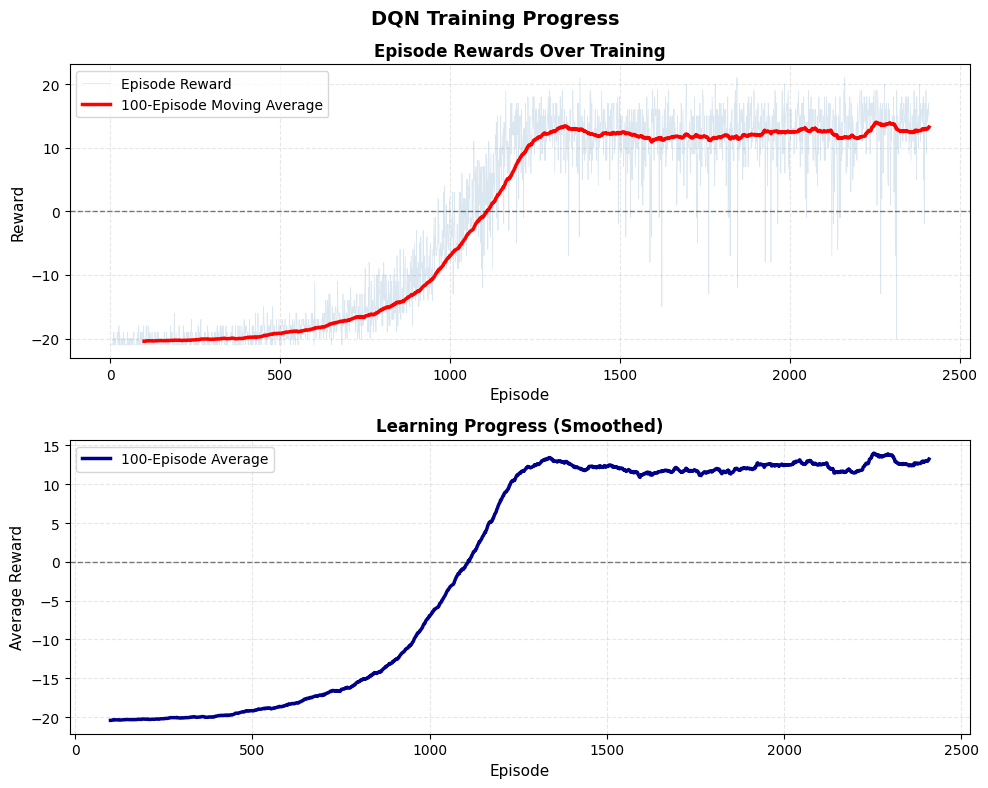

Total Episodes: 2409 | Recent Average (last 100): 13.24


In [16]:
# CELL 7: Plot Training Statistics

import matplotlib.pyplot as plt  # Plotting library for creating visualizations
import numpy as np  # Numerical operations for calculating moving averages
from collections import deque  # For checking if episode_rewards is a deque

# Check if episode_rewards exists
# Verify that training data is available
if 'episode_rewards' not in globals():
    print("Training data not found. Please run the training cell first.")
else:
    # Convert deque to list if needed
    # Training cell uses deque for memory efficiency but plotting needs a list
    if isinstance(episode_rewards, deque):
        rewards_list = list(episode_rewards)  # Convert deque to list for plotting
    else:
        rewards_list = episode_rewards  # Already a list use as-is
    
    # Check if we have any data to plot
    if len(rewards_list) == 0:
        print("No episode data available yet.")
    else:
        # Two plots: one showing raw rewards one showing smoothed trend
        fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 2 vertical subplots 10x8 inches
        # Add overall title to the figure
        fig.suptitle('DQN Training Progress', fontsize=14, fontweight='bold')
        
        # Create episode numbers array
        episodes = np.arange(1, len(rewards_list) + 1)
        
        # Plot 1: Episode Rewards with Moving Average
        ax1 = axes[0]  # Get first subplot axis
        # Plot individual episode rewards
        # Shows raw variability in performance
        ax1.plot(episodes, rewards_list, alpha=0.2, color='steelblue', linewidth=0.5, label='Episode Reward')
        
        # Moving average smooths out noise and shows overall learning trend
        window_size = 100  # Number of episodes to average over
        if len(rewards_list) >= window_size:
            # Convolve with uniform window calculates average of last 100 episodes
            # mode='valid' returns only where window fully overlaps
            moving_avg = np.convolve(rewards_list, np.ones(window_size)/window_size, mode='valid')
            # Episode numbers for moving average
            moving_avg_episodes = np.arange(window_size, len(rewards_list) + 1)
            # Plot moving average as prominent red line
            ax1.plot(moving_avg_episodes, moving_avg, color='red', linewidth=2.5, 
                    label='100-Episode Moving Average')
        
        # Configure first plot labels and styling
        ax1.set_xlabel('Episode', fontsize=11)  # X-axis label
        ax1.set_ylabel('Reward', fontsize=11)  # Y-axis label
        ax1.set_title('Episode Rewards Over Training', fontsize=12, fontweight='bold')  # Subplot title
        ax1.grid(True, alpha=0.3, linestyle='--')  # Add grid for easier reading
        ax1.legend(loc='best', fontsize=10)  # Show legend with line labels
        # Add horizontal line at y=0 to mark break-even point
        ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        # Plot 2: Smoothed Average Reward Curve
        ax2 = axes[1]  # Get second subplot axis
        
        # Plot 100-episode moving average
        # This plot focuses only on the smoothed trend
        if len(rewards_list) >= window_size:
            # Recalculate moving average
            moving_avg = np.convolve(rewards_list, np.ones(window_size)/window_size, mode='valid')
            moving_avg_episodes = np.arange(window_size, len(rewards_list) + 1)
            # Plot smoothed curve with prominent blue line
            ax2.plot(moving_avg_episodes, moving_avg, color='darkblue', linewidth=2.5,
                    label='100-Episode Average')
        
        # Configure second plot labels and styling
        ax2.set_xlabel('Episode', fontsize=11)  # X-axis label
        ax2.set_ylabel('Average Reward', fontsize=11)  # Y-axis label
        ax2.set_title('Learning Progress (Smoothed)', fontsize=12, fontweight='bold')  # Subplot title
        ax2.grid(True, alpha=0.3, linestyle='--')  # Add grid
        ax2.legend(loc='best', fontsize=10)  # Show legend
        # Add horizontal line at y=0 to mark break-even point
        ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        # Adjust layout to prevent label overlap
        plt.tight_layout()
        # Display the plot
        plt.show()
        
        # Brief summary
        # Calculate and print recent performance statistics
        # Average of last 100 episodes
        recent_avg = np.mean(rewards_list[-100:]) if len(rewards_list) >= 100 else np.mean(rewards_list)
        print(f"Total Episodes: {len(rewards_list)} | Recent Average (last 100): {recent_avg:.2f}")

## Evaluation 

### How does one evaluate the performance of the RL agent?

To judge how well a reinforcement learning agent is doing, we need measures that show both how it’s improving during training and how good it is once it has learned. For Atari Pong, we use a few different metrics that work well together:

Episode reward: This is the one we focused on the most; the total reward the agent gets in one game. In Pong, it basically means how many points the agent wins or loses. The best possible score is +21 (winning every round) and the worst is -21 (losing every round).

Moving average reward: Episode rewards can be noisy, so we also look at an average over the last 10 or 100 episodes. This makes it easier to see the real trend instead of getting distracted by random spikes.

Learning curve: Plotting reward over time (episodes or training steps) shows if the agent is actually learning. If the graph is generally going up, that’s a good sign. If it flattens out, learning might have stalled, and if it drops, the agent might be getting worse.

Episode length: How long a game lasts may also indicate learning. Early on, short episodes might mean the agent is losing quickly. Longer episodes can mean it’s keeping games going more and surviving longer. But if episodes get too long, it could also mean the agent is playing overly defensive instead of trying to win.

### Results Analysis

To evaluate the performance of the our agent, we looked at the average episode reward over training, as reward is the clearest indicator of whether the Pong policy is improving.  

The episode reward plot is noisy early on, so we used a smoothed curve for clarity, which shows a clear upward trend. This implies that the agent does improve steadily over training.  

In the average reward vs episode plot, we focused on looking at the average of the previous 10 episodes to account for any noise. We measure the agent based on rounds won in a game of Pong, typically being 21 rounds. If the agent scores +21, it has won every round, and if the agent scores –21, it has lost every round.  

You can see on the plot in the beginning the performance is almost random and the agent is not winning many games if any. At around 700 episodes, we begin to see the agent start steadily climbing and after around 1200 episodes we see a reward of ~14. After this the agent consistently wins games at this score.

In the attached epsilon vs steps plot visualises the agent's exploration vs exploitation. It shows exploration decaying to 0.1, and rewards keep improving even after epsilon reaches its minimum, suggesting learning continues through better Q-value estimates rather than just exploration. 

Finally, the attached average episode length vs steps plot visualises the average episode length being short in the beginning, as the agent doesn't know how to play, then increases as it learns the game, and finally decreases and evens out showing that the agent has learnt the game well enough to rally against it's opponent on an 'even playing field'.

Overall, the results show that the DQN agent learned an effective Pong policy, moving from near-random play to consistently positive rewards as training progressed.

In [ ]:
# CELL 8: Evaluation and Visualization

import matplotlib.pyplot as plt  # For creating plots and animations
import matplotlib.animation as animation  # For creating animated visualizations
from IPython.display import HTML, display  # For displaying HTML animations in notebook

def make_eval_env(env_id='ALE/Pong-v5', render_mode='rgb_array'):
    """Create environment for evaluation with rendering."""
    # Create base environment with rendering enabled
    base_env = gym.make(env_id, frameskip=1, repeat_action_probability=0.0, 
                       full_action_space=False, render_mode=render_mode)
    # Apply same preprocessing wrappers as training
    env = NoopResetEnv(base_env, noop_max=30)  # Random no-ops at start
    env = FireResetEnv(env)  # Press FIRE to begin
    env = MaxAndSkipEnv(env, skip=4)  # Frame skipping
    env = WarpFrame(env)  # Grayscale and resize
    env = ClipRewardEnv(env)  # Clip rewards
    env = FrameStack(env, k=4)  # Stack frames
    # Return both: wrapped env for agent, base_env for rendering
    return env, base_env

def evaluate_and_visualize(model_path, n_episodes=1, max_steps=5000):
    """Evaluate model and show simple animated gameplay."""
    print(f"Loading model: {model_path}")
    
    # Check if model file exists
    if not os.path.exists(model_path):
        print(f"Model not found: {model_path}")
        return
    
    # Setup environment and agent
    # Create evaluation environment with rendering enabled
    eval_env, base_env = make_eval_env('ALE/Pong-v5', render_mode='rgb_array')
    # Create agent with zero exploration (pure greedy policy for evaluation)
    eval_agent = DQNAgent(n_actions=eval_env.action_space.n, device=device,
                         epsilon_start=0.0, epsilon_end=0.0, buffer_size=1000)  # No exploration
    # Load trained model weights
    eval_agent.load(model_path)
    # Set network to evaluation mode
    eval_agent.q_network.eval()
    
    # Run episode and collect frames
    # Reset environment to start new episode
    state, _ = eval_env.reset()
    frames = []  # List to store rendered frames for animation
    total_reward = 0  # Track cumulative reward for episode
    
    # Run episode for up to max_steps
    for step in range(max_steps):
        # Get action from trained network
        # Disable gradient computation for inference
        with torch.no_grad():
            # Convert state to tensor and add batch dimension
            state_tensor = torch.tensor(state, dtype=torch.uint8, device=device).unsqueeze(0)
            # Forward pass: get Q-values and select best action
            action = eval_agent.q_network(state_tensor).argmax(1).item()
        
        # Execute action in environment
        next_state, reward, terminated, truncated, _ = eval_env.step(action)
        total_reward += reward  # Accumulate reward
        done = terminated or truncated  # Check if episode ended
        
        # Capture frame
        # Render current frame from base environment
        frame = base_env.render()
        if frame is not None:
            frames.append(frame)  # Store frame for animation
        
        # End episode if done
        if done:
            break
        state = next_state  # Move to next state
    
    # Clean up environments
    eval_env.close()
    base_env.close()
    
    # Print episode results
    print(f"Episode Reward: {total_reward:+.1f} | Steps: {len(frames)}")
    
    # Display animation
    if len(frames) > 0:
        # Downsample for smoother animation
        # Limit to ~200 frames for reasonable animation size and speed
        step = max(1, len(frames) // 200)  # Calculate step size
        frames_to_show = frames[::step]  # Take every Nth frame
        
        # Create figure for animation
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.axis('off')  # Hide axes for cleaner display
        # Set title with episode reward
        ax.set_title(f'DQN Playing Pong (Reward: {total_reward:+.1f})', fontsize=12, fontweight='bold')
        
        # Initialize image display with first frame
        im = ax.imshow(frames_to_show[0])
        
        def animate(i):
            """Animation function: updates frame for each animation step."""
            # Update image with current frame
            im.set_array(frames_to_show[i % len(frames_to_show)])
            return [im]  # Return list of artists to update
        
        # Create animation: updates every 50ms
        anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_show), 
                                       interval=50, blit=True, repeat=True)
        plt.close()  # Close figure
        # Convert animation to HTML and display in notebook
        display(HTML(anim.to_jshtml()))
        print("Displaying animation")

# Print ready message when cell is executed
print("Ready")


Ready


In [19]:
# CELL 9: Visualize the Trained Model

evaluate_and_visualize('models/dqn_pong_final.pth')


Loading model: models/dqn_pong_final.pth
Episode Reward: +21.0 | Steps: 1631


Displaying animation


##References

DQN Atari pong implementation: https://github.com/qingshi9974/DQN-pytorch-Atari/blob/master/dqn.py

OpenAI Wrappers: https://github.com/openai/baselines/blob/edb52c22a5e14324304a491edc0f91b6cc07453b/baselines/common/atari_wrappers.py

Gynmasium Documentation: https://gymnasium.farama.org/

Matplotlib Animation Documentation: https://matplotlib.org/stable/api/animation_api.html